In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("KODEX200_monthly_data.csv", encoding="utf-8")

### Index는 datetime 형으로 변환하기

In [3]:
df.index = pd.to_datetime(df["Date"])
df.head()

,Date,Open,High,Low,Close,Volume,Change
Date,,,,,,,
2010-01-29,2010-01-29,19052,19066,18668,18742,2717811,-0.026996
2010-02-26,2010-02-26,18611,18683,18514,18559,974615,0.000431
2010-03-31,2010-03-31,19853,19858,19729,19789,883019,-0.003776
2010-04-30,2010-04-30,20331,20403,20313,20377,758179,0.007814
2010-05-31,2010-05-31,18887,19126,18882,19134,1979678,0.012220


### 함수들

In [4]:
# 평균모멘텀 구하기
def 평균모멘텀구하기(data,month):
    result = 0
    for i in range(1,(month+1),1):
        result = data / data.shift(i) + result
    return result/month

# 평균모멘텀 스코어 구하기
def 평균모멘텀스코어구하기(data,month=12):
    result = 0
    for i in range(1,(month+1),1):
        result = np.where(data / data.shift(i) > 1,1,0) + result
    score = pd.DataFrame(np.round(result/month,2), index=data.index,columns=["12M_Score"]) 
    return score

def MA스코어구하기(data,month=12):
    #현재 1개월 데이터로 ma1 구하는것은 의미없음, 나중에 실전에서는 20일 이동평균으로 대체 할수 있음
    ma1 = np.round(data.rolling(window=1).mean().fillna(0),2); ma1.rename("ma1", inplace=True)
    ma2 = np.round(data.rolling(window=2).mean().fillna(0),2); ma2.rename("ma2", inplace=True)
    ma3 = np.round(data.rolling(window=3).mean().fillna(0),2); ma3.rename("ma3", inplace=True)
    ma4 = np.round(data.rolling(window=4).mean().fillna(0),2); ma4.rename("ma4", inplace=True)
    ma5 = np.round(data.rolling(window=5).mean().fillna(0),2); ma5.rename("ma5", inplace=True)
    ma6 = np.round(data.rolling(window=6).mean().fillna(0),2); ma6.rename("ma6", inplace=True)
    ma7 = np.round(data.rolling(window=7).mean().fillna(0),2); ma7.rename("ma7", inplace=True)
    ma8 = np.round(data.rolling(window=8).mean().fillna(0),2); ma8.rename("ma8", inplace=True)
    ma9 = np.round(data.rolling(window=9).mean().fillna(0),2); ma9.rename("ma9", inplace=True)
    ma10 = np.round(data.rolling(window=10).mean().fillna(0),2); ma10.rename("ma10", inplace=True)
    ma11 = np.round(data.rolling(window=11).mean().fillna(0),2); ma11.rename("ma11", inplace=True)
    ma12 = np.round(data.rolling(window=12).mean().fillna(0),2); ma12.rename("ma12", inplace=True)

    result = 0 
    result = np.where(data>ma1,1,0) + result
    result = np.where(data>ma2,1,0) + result
    result = np.where(data>ma3,1,0) + result
    result = np.where(data>ma4,1,0) + result
    result = np.where(data>ma5,1,0) + result
    result = np.where(data>ma6,1,0) + result
    result = np.where(data>ma7,1,0) + result
    result = np.where(data>ma8,1,0) + result
    result = np.where(data>ma9,1,0) + result
    result = np.where(data>ma10,1,0) + result
    result = np.where(data>ma11,1,0) + result
    result = np.where(data>ma12,1,0) + result
    # 11개월 평균 스코어를 구함
    score = pd.DataFrame(np.round(result/month,2), index=data.index, columns=["MA12_Score"])
    return score

def MA스코어구하기6(data,month=6):
    #현재 1개월 데이터로 ma1 구하는것은 의미없음, 나중에 실전에서는 20일 이동평균으로 대체 할수 있음
    ma1 = np.round(data.rolling(window=1).mean().fillna(0),2); ma1.rename("ma1", inplace=True)
    ma2 = np.round(data.rolling(window=2).mean().fillna(0),2); ma2.rename("ma2", inplace=True)
    ma3 = np.round(data.rolling(window=3).mean().fillna(0),2); ma3.rename("ma3", inplace=True)
    ma4 = np.round(data.rolling(window=4).mean().fillna(0),2); ma4.rename("ma4", inplace=True)
    ma5 = np.round(data.rolling(window=5).mean().fillna(0),2); ma5.rename("ma5", inplace=True)
    ma6 = np.round(data.rolling(window=6).mean().fillna(0),2); ma6.rename("ma6", inplace=True)

    result = 0 
    result = np.where(data>ma1,1,0) + result
    result = np.where(data>ma2,1,0) + result
    result = np.where(data>ma3,1,0) + result
    result = np.where(data>ma4,1,0) + result
    result = np.where(data>ma5,1,0) + result
    result = np.where(data>ma6,1,0) + result
    
    score = pd.DataFrame(np.round(result/month,2), index=data.index, columns=["MA6_Score"])
    return score

### 월별 수익
def 월별수익(data):
    return np.round(data/data.shift(1),2)

### 전략 수익 데이타만들기

In [5]:
#1. 자본금 초기화
balance = 1000000

#2. 12개월 평균모멘텀 스코어
kodex200 = df["Close"]; kodex200.rename("KODEX200", inplace=True)
score12 = 평균모멘텀스코어구하기(kodex200,12)
#2-1. 12개월 MA 스코어
MA12_score = MA스코어구하기(kodex200,12)
#2-2. 6개월 MA 스코어
MA6_Score =  MA스코어구하기6(kodex200,6)

# 스코어 2개를 합쳐서 평균값으로 스코어 사용
a = score12.copy()
a.rename(columns={"12M_Score":"score"},inplace=True)
b = MA12_score.copy()
b.rename(columns={"MA12_Score":"score"},inplace=True)
스코어 = (a+b)/2
# 2개 값을 합치고 2로 나누고 스코어 구해서 했으나 결과는 나쁨.

# 평균모멘텀스코어와 종목["Close"] 합침
momentum12 = pd.concat([kodex200, score12, MA12_score, MA6_Score], axis=1)

#3. system stop = market score, 이동평균으로 구하기, Nan값은 0으로 채움
# momentum12["market_score_ma5"] = np.round(momentum12["12M_Score"].rolling(window=5).mean().fillna(0),2)

#3. system stop = market score, 이동평균으로 구하기, Nan값은 0으로 채움
#momentum12["market_score_ma5"] = np.round(momentum12["MA6_Score"].rolling(window=5).mean().fillna(0),2)
momentum12["market_score_ma5"] = np.round(스코어.rolling(window=5).mean().fillna(0),2)

#4 월별수익
momentum12["월별수익"] = 월별수익(momentum12["KODEX200"])

#4. market score * 잔고 = 투자금액
#5. 투자금액 * 12개월 평균 스코어 = 매수가능금액
#6. 매수가능금액 / 현재가(Close) = 구매가능수량
#7. 구매가능수량 * 현재가(Close) = 매수금액
#8. 잔고 - 매수금액 = 현금
#9. 월별수익 * 매수금액 = 매도금액
#10. 수수료
#11 현금 + 매도금액 = 잔고

스코어금액 = []
매수가능금액 = []
구매수량 = []
매수금액 = []
매도금액 = []
현금 = []
잔고 = [1000000]
# 현금 혼합비율,1이면 100%
현금비율 = 1
# 증권거래서 없음
수수료 = 0

for i in range(0,len(momentum12)):
    # 마켓스코어 계산을 통해 현금:투자금액 비율을 구한다.
    스코어금액.append(np.round(잔고[i] * momentum12["market_score_ma5"][i]))
    
    # 해당 종목의 12개월 평균모멘텀 점수만큼 매수한다.
    # 매수가능금액.append(np.round(스코어금액[i] * momentum12["12M_Score"][i]))
    
    # 현금비율과 12개월 모멘텀 스코어 비율을 계산하여 
    #매수가능비율 = np.round(momentum12["12M_Score"][i]/(momentum12["12M_Score"][i]+현금비율),2)
    
    # 현금비율과 12개월 MA 스코어 비율을 계산하여 
    매수가능비율 = np.round(momentum12["MA6_Score"][i]/(momentum12["MA6_Score"][i]+현금비율),2)
    #매수가능비율 = np.round(스코어.iloc[i]/(스코어.iloc[i]+현금비율),2)
    
    # 매수가능금액.append(np.round(잔고[i] * 매수가능비율))
    매수가능금액.append(np.round(스코어금액[i] * 매수가능비율))
    구매수량.append(np.round(매수가능금액[i] / momentum12["KODEX200"][i]))
    매수금액.append(np.round(구매수량[i] * momentum12["KODEX200"][i]))
    # 매수금액 : 현금을 구한다
    현금.append(잔고[i] - 매수금액[i])
    # 이번달 투자금액 * 다음달 월별수익
    try:
        # 이번달 수익은 다음달 월별수익으로 알수있다.
        매도 = 매수금액[i] * momentum12["월별수익"][i+1]
    except IndexError:
        매도 = 매수금액[i]
    # 수수료를 반영하여 실전 평가한다.
    매도금액.append(np.round(매도 - 매도*수수료))
    # 다음달 잔고는 이번달 현금과 매도금액이다.
    잔고.append(현금[i] + 매도금액[i])
    

In [6]:
# Series & DataFrame 합치기
# 스코어금액 = pd.Series(스코어금액,index=momentum12.index, name = "스코어금액")
매수가능금액 = pd.Series(매수가능금액,index=momentum12.index, name = "매수가능금액")
구매수량 = pd.Series(구매수량,index=momentum12.index, name = "구매수량")
매수금액 = pd.Series(매수금액,index=momentum12.index, name = "매수금액")
매도금액 = pd.Series(매도금액,index=momentum12.index, name = "매도금액")
현금 = pd.Series(현금,index=momentum12.index, name = "현금")
# 마지막 데이터 저장시 길이가 +1만큼 길어져 삭제함
del 잔고[-1]
잔고 = pd.Series(잔고,index=momentum12.index, name = "잔고")

# momentum12 = pd.concat([momentum12,스코어금액,매수가능금액,구매수량,매수금액,매도금액,현금,잔고], axis=1)
momentum12 = pd.concat([momentum12,매수가능금액,구매수량,매수금액,매도금액,현금,잔고], axis=1)
momentum12.tail()

,KODEX200,12M_Score,MA12_Score,MA6_Score,market_score_ma5,월별수익,매수가능금액,구매수량,매수금액,매도금액,현금,잔고
Date,,,,,,,,,,,,
2018-09-28,30033,0.25,0.25,0.50,0.11,1.01,38122.0,1.0,30033.0,26429.0,1020165.0,1050198.0
2018-10-31,26390,0.00,0.00,0.00,0.08,0.88,0.0,0.0,0.0,0.0,1046594.0,1046594.0
2018-11-30,27160,0.08,0.08,0.17,0.09,1.03,14129.0,1.0,27160.0,26617.0,1019434.0,1046594.0
2018-12-31,26580,0.08,0.00,0.00,0.10,0.98,0.0,0.0,0.0,0.0,1046051.0,1046051.0
2019-01-31,26215,0.00,0.00,0.00,0.07,0.99,0.0,0.0,0.0,0.0,1046051.0,1046051.0


### csv파일로 저장하기

In [7]:
momentum12.to_csv("kodex200.csv",encoding="euc_kr", sep=",")

### 수익률 구하기

In [8]:
# 포트폴리오, CAGR구하기
# The $1,000 would be the F in our formula, L would be $1,980 and N would be 6 (number of years).
y = momentum12.index.year.unique()
포트폴리오CAGR = (momentum12["잔고"][-1]/momentum12["잔고"][0])**(1/len(y))-1
print ("포트폴리오 CAGR {:.2%} ".format(포트폴리오CAGR))

# KODEX200, CAGR구하기
# The $1,000 would be the F in our formula, L would be $1,980 and N would be 6 (number of years).
y = momentum12.index.year.unique()
KODEX200CAGR = (momentum12["KODEX200"][-1]/momentum12["KODEX200"][0])**(1/len(y))-1
print ("KODEX200 CAGR {:.2%} ".format(KODEX200CAGR))

포트폴리오 CAGR 0.45% 
KODEX200 CAGR 3.41% 


In [9]:
# 포트폴리오 MDD 구하기
# We are going to use a trailing 252 trading day window
window = len(momentum12)

# Calculate the max drawdown in the past window days for each day in the series.
# Use min_periods=1 if you want to let the first 252 days data have an expanding window
Roll_Max = momentum12['잔고'].rolling(window, min_periods=1).max()
Roll_Max.rename("Roll_Max", inplace=True)
Daily_포트폴리오_Drawdown = momentum12['잔고']/Roll_Max - 1.0
Daily_포트폴리오_Drawdown.rename("포트폴리오 Daily_Drawdown", inplace=True)

# Next we calculate the minimum (negative) daily drawdown in that window.
# Again, use min_periods=1 if you want to allow the expanding window
Max_포트폴리오_Daily_Drawdown = Daily_포트폴리오_Drawdown.rolling(window, min_periods=1).min()
Max_포트폴리오_Daily_Drawdown.rename("포트폴리오 Max_Daily_Drawdown", inplace=True)
print ("포트폴리오 MDD {:.2%}".format(Max_포트폴리오_Daily_Drawdown[-1]))

# KODEX200 MDD 구하기
# We are going to use a trailing 252 trading day window
window = len(momentum12)

# Calculate the max drawdown in the past window days for each day in the series.
# Use min_periods=1 if you want to let the first 252 days data have an expanding window
Roll_Max = momentum12['KODEX200'].rolling(window, min_periods=1).max()
Roll_Max.rename("Roll_Max", inplace=True)
Daily_KODEX200_Drawdown = momentum12['KODEX200']/Roll_Max - 1.0
Daily_KODEX200_Drawdown.rename("KODEX200 Daily_Drawdown", inplace=True)

# Next we calculate the minimum (negative) daily drawdown in that window.
# Again, use min_periods=1 if you want to allow the expanding window
Max_KODEX200_Daily_Drawdown = Daily_KODEX200_Drawdown.rolling(window, min_periods=1).min()
Max_KODEX200_Daily_Drawdown.rename("KODEX200 Max_Daily_Drawdown", inplace=True)
print ("KODEX200 MDD {:.2%}".format(Max_KODEX200_Daily_Drawdown[-1]))

포트폴리오 MDD -9.42%
KODEX200 MDD -20.68%


In [10]:
print ("현금비율 :",현금비율)
print ("포트폴리오 CAGR {:.2%} ".format(포트폴리오CAGR))
print ("KODEX200 CAGR {:.2%} ".format(KODEX200CAGR))
print ("포트폴리오 MDD {:.2%}".format(Max_포트폴리오_Daily_Drawdown[-1]))
print ("KODEX200 MDD {:.2%}".format(Max_KODEX200_Daily_Drawdown[-1]))

현금비율 : 1
포트폴리오 CAGR 0.45% 
KODEX200 CAGR 3.41% 
포트폴리오 MDD -9.42%
KODEX200 MDD -20.68%


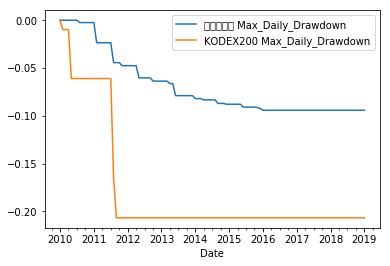

In [11]:
# Plot the results
Max_포트폴리오_Daily_Drawdown.plot(legend="포트폴리오")
Max_KODEX200_Daily_Drawdown.plot(legend="KODEX200")

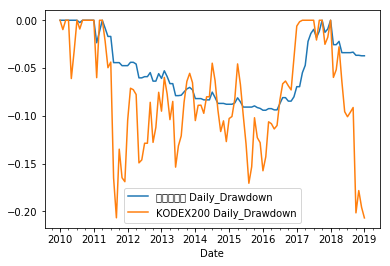

In [12]:
# Plot the results
Daily_포트폴리오_Drawdown.plot(legend="포트폴리오")
Daily_KODEX200_Drawdown.plot(legend="KODEX200")

### 그래프 그리기

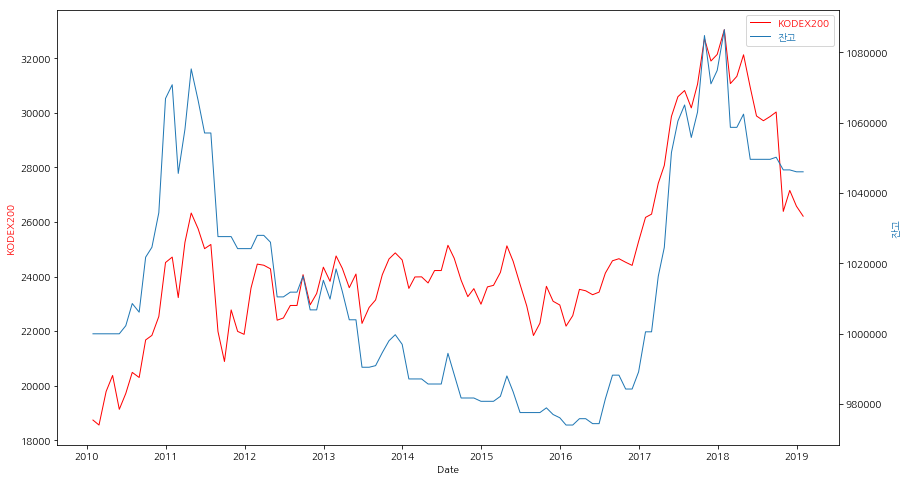

In [13]:
from mpl_toolkits.axes_grid1 import host_subplot
import matplotlib.pyplot as plt
from matplotlib import rc, font_manager
rc("font", family="NanumGothic")

plt.rcParams["figure.figsize"] = (14,8)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.grid'] = False 

host = host_subplot(111)
par = host.twinx()

host.set_xlabel("Date")
host.set_ylabel("KODEX200")
par.set_ylabel("잔고")

p1, = host.plot(momentum12["KODEX200"], label="KODEX200",color = "R")
p2, = par.plot(momentum12["잔고"], label="잔고")
#p2, = par.plot(momentum6["KODEX200"], label="6Score")

leg = plt.legend()

host.yaxis.get_label().set_color("R")
leg.texts[0].set_color("R")

par.yaxis.get_label().set_color(p2.get_color())
leg.texts[1].set_color(p2.get_color())

plt.show()

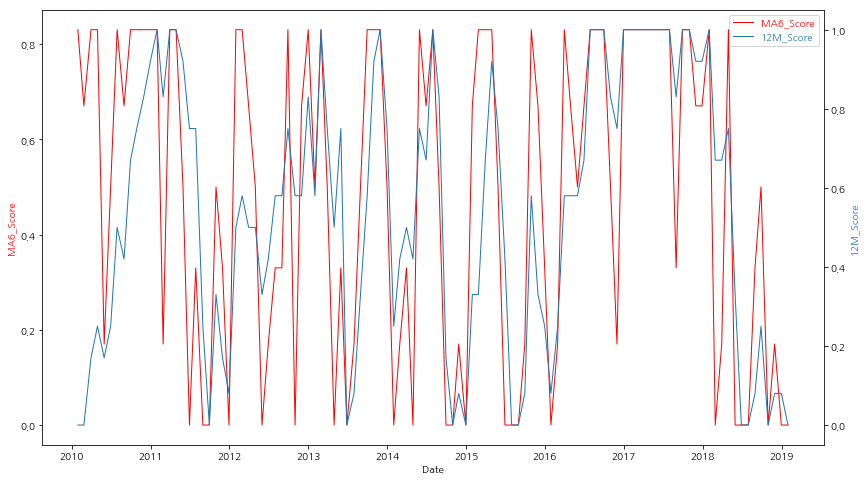

In [14]:
from mpl_toolkits.axes_grid1 import host_subplot
import matplotlib.pyplot as plt
from matplotlib import rc, font_manager
rc("font", family="NanumGothic")

plt.rcParams["figure.figsize"] = (14,8)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.grid'] = False 

host = host_subplot(111)
par = host.twinx()

host.set_xlabel("Date")
host.set_ylabel("MA6_Score")
par.set_ylabel("12M_Score")

p1, = host.plot(momentum12["MA6_Score"], label="MA6_Score",color = "R")
p2, = par.plot(momentum12["12M_Score"], label="12M_Score")
#p2, = par.plot(momentum6["KODEX200"], label="6Score")

leg = plt.legend()

host.yaxis.get_label().set_color("R")
leg.texts[0].set_color("R")

par.yaxis.get_label().set_color(p2.get_color())
leg.texts[1].set_color(p2.get_color())

plt.show()

### 자본의 수익곡선

In [15]:
잔고6 = np.round(momentum12["잔고"].rolling(window=6).mean())

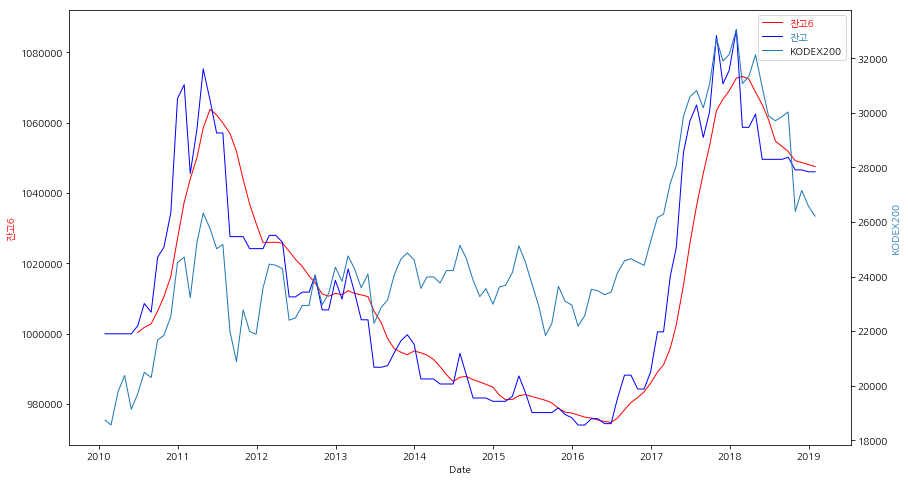

In [16]:
from mpl_toolkits.axes_grid1 import host_subplot
import matplotlib.pyplot as plt
from matplotlib import rc, font_manager
rc("font", family="NanumGothic")

host = host_subplot(111)
par = host.twinx()

host.set_xlabel("Date")
host.set_ylabel("잔고6")
par.set_ylabel("KODEX200")

p1, = host.plot(잔고6, label="잔고6",color = "R")
p1, = host.plot(momentum12["잔고"], label="잔고",color = "B")
p2, = par.plot(momentum12["KODEX200"], label="KODEX200")
#p2, = par.plot(momentum6["KODEX200"], label="6Score")

leg = plt.legend()

host.yaxis.get_label().set_color("R")
leg.texts[0].set_color("R")

par.yaxis.get_label().set_color(p2.get_color())
leg.texts[1].set_color(p2.get_color())

plt.show()

### 수익곡선 이평구하기

In [17]:
# 이평 구하기
ma3 = momentum12["KODEX200"].rolling(window=3).mean()
ma4 = momentum12["KODEX200"].rolling(window=4).mean()
ma5 = momentum12["KODEX200"].rolling(window=5).mean()  # 5개월
ma6 = momentum12["KODEX200"].rolling(window=6).mean()

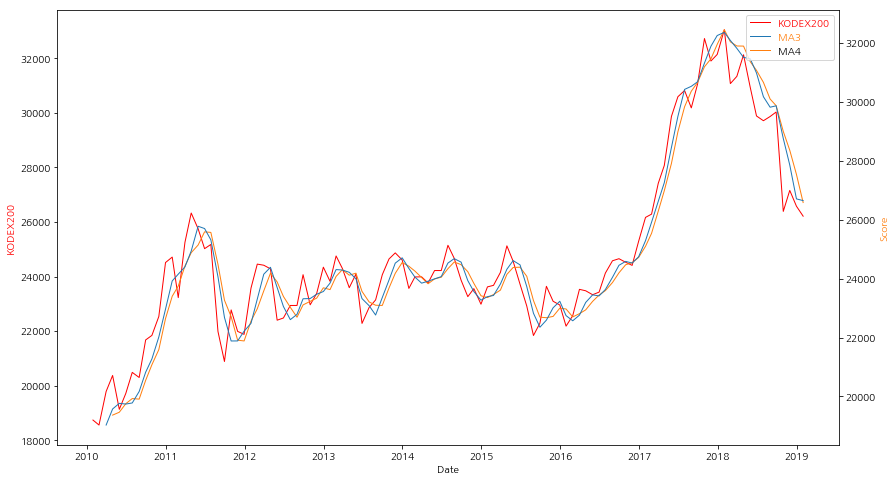

In [18]:
# 그래프 그리기
from mpl_toolkits.axes_grid1 import host_subplot
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (14,8)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.grid'] = False 

host = host_subplot(111)
par = host.twinx()

host.set_xlabel("Date")
host.set_ylabel("KODEX200")
par.set_ylabel("Score")

p1, = host.plot(momentum12["KODEX200"], label="KODEX200",color = "R")
#p2, = par.plot(momentum12["score"], label="12Score")
p2, = par.plot(ma3, label="MA3")
p2, = par.plot(ma4, label="MA4")
#p2, = par.plot(ma5, label="MA5")
#p2, = par.plot(ma6, label="MA")

leg = plt.legend()

host.yaxis.get_label().set_color("R")
leg.texts[0].set_color("R")

par.yaxis.get_label().set_color(p2.get_color())
leg.texts[1].set_color(p2.get_color())

plt.show()